In [20]:
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.optim as optim
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [21]:
# import re
# def get_translation_texts(input_file='data/deu.txt', output_file='data/en-de.txt'):
#   regex = r"\tCC-BY 2.0.+$"
#   lines = open(input_file, encoding='utf-8').read().strip().split('\n')
#   lines = [re.sub(regex, '', line) for line in lines]
#   file = open(output_file,'w')
#   for line in lines:
#     file.write(line+"\n")
#   file.close()

# get_translation_texts()

In [22]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)

In [23]:
device = torch.device('cpu')
max_lines = None
batch_size = 128

In [24]:
lang1 = 'en'
lang2 = 'de'

en_tokenizer = get_tokenizer('spacy', language='en_core_web_md')
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

def lang1_tokenizer(sentence):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [token.lower() for token in en_tokenizer(sentence)]

def lang2_tokenizer(sentence):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [token for token in de_tokenizer(sentence)]

def build_vocab(lang1='en', lang2='de'):
    counter1 = Counter()
    counter2 = Counter()
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    for l in lines:
        l1, l2 = l.split('\t')
        counter1.update(lang1_tokenizer(l1))
        counter2.update(lang2_tokenizer(l2))

    vocab1 = vocab(counter1, min_freq=2, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
    vocab2 = vocab(counter2, min_freq=2, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
    vocab1.set_default_index(vocab1["<unk>"])
    vocab2.set_default_index(vocab2["<unk>"])
    return [vocab1, vocab2]

lang1_vocab, lang2_vocab = build_vocab(lang1, lang2)
lang1_vocab_size = len(lang1_vocab)
lang2_vocab_size = len(lang2_vocab)
print('lang1_vocab_vocab_size', lang1_vocab_size)
print('lang2_vocab_size', lang2_vocab_size)

lang1_vocab_vocab_size 12030
lang2_vocab_size 23470


In [25]:
class TranslationDataset(Dataset):
    def __init__(self, lang1, lang2, max_lines, device=torch.device("cpu")):
        self.lang1 = lang1
        self.lang2 = lang2
        self.device = device
        self.data = []
        self.untokenized_data = []
        lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
        lines.reverse() #use longer data
        num_lines = 0
        for l in lines:
            l1, l2 = l.split('\t')
            if (max_lines is None or max_lines > num_lines):
                l1_tokens = self.tokenize_sentence(l1, True)
                l2_tokens = self.tokenize_sentence(l2, False)
                self.data.append((l1_tokens, l2_tokens))
                self.untokenized_data.append((l1, l2))
                num_lines += 1

        self.len = len(self.data)

    def tokenize_sentence(self, sentence, is_lang1):
        vocab = lang1_vocab if is_lang1 else lang2_vocab
        tokenizer = lang1_tokenizer if is_lang1 else lang2_tokenizer
        indexes = [vocab[token] for token in tokenizer(sentence)]
        indexes = [vocab['<sos>']] + indexes + [vocab['<eos>']]
        return torch.tensor(indexes, dtype=torch.long, device=self.device)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

In [26]:
dataset = TranslationDataset(lang1, lang2, max_lines, device)
print('length of dataset', len(dataset))

length of dataset 260433


In [27]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(SEED))

def collate_fn(batch):
    source = [item[0] for item in batch] 
    #pad them using pad_sequence method from pytorch. 
    source = pad_sequence(source, batch_first=True, padding_value=lang1_vocab['<pad>']) 
    
    #get all target indexed sentences of the batch
    target = [item[1] for item in batch] 
    #pad them using pad_sequence method from pytorch. 
    target = pad_sequence(target, batch_first=True, padding_value=lang2_vocab['<pad>'])
    return source, target

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print('length of train_loader', len(train_loader))
print('length of val_loader', len(val_loader))
print('length of test_loader', len(test_loader))


length of train_loader 1628
length of val_loader 204
length of test_loader 204


In [28]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)
    print([item[0]])
    print([item[1]])
    break

torch.Size([128, 18]) torch.Size([128, 22])
[tensor([[   2,  232,  115,  ...,    1,    1,    1],
        [   2,   69,  179,  ...,    1,    1,    1],
        [   2,   22,  105,  ...,    1,    1,    1],
        ...,
        [   2,  659, 1245,  ...,    1,    1,    1],
        [   2,   22,  878,  ...,    1,    1,    1],
        [   2,   69,  539,  ...,    1,    1,    1]])]
[tensor([[   2,  426,   25,  ...,    1,    1,    1],
        [   2,  133,  268,  ...,    1,    1,    1],
        [   2,   32, 2720,  ...,    1,    1,    1],
        ...,
        [   2, 1215, 2388,  ...,    1,    1,    1],
        [   2,   32,  624,  ...,    1,    1,    1],
        [   2,  133, 3060,  ...,    1,    1,    1]])]


In [29]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        #input = (batch_size, seq_len)
        batch_size = input.size(0)
        seq_len = input.size(1)
        
        #create position tensor, pos = [0, 1, 2, 3, ..., seq_len - 1], pos = (batch_size, seq_len)
        pos = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #embed tokens and positions, tok_embedded = pos_embedded = [batch_size, seq_len, emb_dim]
        tok_embedded = self.tok_embedding(input)
        pos_embedded = self.pos_embedding(pos)
        
        #combine embeddings by elementwise summing, [batch_size, seq_len, emb_dim]
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #pass embedded through linear layer to convert from emb_dim to hid_dim
        conv_input = self.emb2hid(embedded) # [batch_size, seq_len, emb_dim]
                
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) # [batch_size, hid_dim, seq_len]
        
        #begin convolutional blocks...
        for i, conv in enumerate(self.convs):
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input)) # [batch_size, 2 * hid_dim, seq_len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1) # [batch_size, hid_dim, seq_len]

            #apply residual connection
            conved = (conved + conv_input) * self.scale #[batch_size, hid_dim, seq_len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb_dim
        conved = self.hid2emb(conved.permute(0, 2, 1)) #[batch_size, seq_len, emb_dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention # [seq_len, batch_size, emb_dim]
        combined = (conved + embedded) * self.scale
        
        return conved, combined

In [30]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch_size, seq_len, emb_dim]
        #conved = [batch_size, hid_dim, seq_len]
        #encoder_conved = encoder_combined = [batch_size, seq_len, emb_dim]
        
        #permute and convert back to emb_dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1)) #[batch_size, seq_len, emb_dim]
        
        combined = (conved_emb + embedded) * self.scale #[batch_size, seq_len, emb_dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1)) # [batch_size, seq_len, seq_len]
        
        attention = F.softmax(energy, dim=2) # [batch_size, seq_len, seq_len]

        attended_encoding = torch.matmul(attention, encoder_combined) # [batch_size, seq_len, emd_dim]
        
        attended_encoding = self.attn_emb2hid(attended_encoding) # [batch_size, seq_len, hid_dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale # [batch_size, hid_dim, seq_len]
 
        return attention, attended_combined
        
    def forward(self, target, encoder_conved, encoder_combined):
        
        #trg = [batch_size, seq_len]
        #encoder_conved = encoder_combined = [batch_size, seq_len, emb_dim]
                
        batch_size = target.size(0)
        seq_len = target.size(1)
            
        #create position tensor
        pos = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) #[batch_size, seq_len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(target) # [batch_size, seq_len, emb_dim]
        pos_embedded = self.pos_embedding(pos) # [batch_size, seq_len, emb_dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded) # [batch_size, seq_len, emb_dim]
        
        #pass embedded through linear layer to go through emb_dim -> hid_dim
        conv_input = self.emb2hid(embedded) # [batch_size, seq_len, hid_dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) # [batch_size, hid_dim, seq_len]
        
        batch_size = target.size(0)
        hid_dim = conv_input.size(1)
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2) # [batch_size, hid_dim, seq_len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input) # [batch_size, 2 * hid_dim, seq_len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1) # [batch_size, hid_dim, seq_len]
            
            #calculate attention, [batch_size, seq_len, seq_len]
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale # [batch_size, hid_dim, seq_len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1)) # [batch_size, seq_len, emb_dim]
            
        output = self.fc_out(self.dropout(conved)) # [batch_size, seq_len, output dim]
            
        return output, attention

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input, target):
        
        #input = [batch_size, seq_len]
        #target = [batch_size, trg_len-1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv block
        #encoder_combined is encoder_conved plus (elementwise) input embedding plus positional embeddings 
        encoder_conved, encoder_combined = self.encoder(input) # both are [batch_size, seq_len, emb dim]
            
        #calculate predictions of next words
        #output is a batch of predictions for each word in the target sentence
        #attention a batch of attention scores across the input sentence for each word in the target sentence
        output, attention = self.decoder(target, encoder_conved, encoder_combined)
        
        #output = [batch_size, trg_len-1, output_dim], attention = [batch_size, trg_len-1, seq_len]
        
        return output, attention

In [32]:
INPUT_DIM = lang1_vocab_size
OUTPUT_DIM = lang2_vocab_size
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = lang2_vocab['<pad>']
max_length = 100
model_path = 'models/seq2seq_cnn.pt'

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device, 100)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, 100)

model = Seq2Seq(encoder, decoder).to(device)

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 47,437,486 trainable parameters


In [34]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [35]:
print_every = 50
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    print_loss_total = 0
    
    for i, (input, target) in enumerate(iterator):
        #input = [batch_size, seq_len]
        #target = [batch_size, trg_len]

        optimizer.zero_grad()
        
        output, _ = model(input, target[:,:-1]) # [batch_size, trg_len-1, output_dim]
        
        output_dim = output.size(-1)
        
        output = output.contiguous().view(-1, output_dim) # [batch_size * (trg_len-1), output_dim]
        target = target[:,1:].contiguous().view(-1) # [batch_size * (trg_len - 1)]
        
        loss = criterion(output, target)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        print_loss_total += loss.item()
        if(i+1 % print_every == 0):
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (i, i / len(iterator) * 100, print_loss_avg))
        
    return epoch_loss / len(iterator)

In [36]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (input, target) in enumerate(iterator):
            #input = [batch_size, seq_len]
            #target = [batch_size, trg_len]

            output, _ = model(input, target[:,:-1]) # [batch_size, trg_len-1, output_dim]
        
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim) # [batch_size * (trg_len-1), output_dim]
            target = target[:,1:].contiguous().view(-1) # [batch_size * (trg_len - 1)]
            
            loss = criterion(output, target)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
N_EPOCHS = 1
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 294m 43s
	Train Loss: 170394.882
	 Val. Loss: 92989.605


In [39]:
def translate_sentence(sentence, max_length=max_length):
    model.eval()
    with torch.no_grad():
        inputs = dataset.tokenize_sentence(sentence, True)
        inputs = torch.LongTensor(inputs).unsqueeze(0).to(device)

        encoder_conved, encoder_combined = model.encoder(inputs)

        target = [lang2_vocab['<sos>']]

        for i in range(max_length):

            target_tensor = torch.LongTensor(target).unsqueeze(0).to(device)

            with torch.no_grad():
                output, attention = model.decoder(target_tensor, encoder_conved, encoder_combined)
            
            pred_token = output.argmax(2)[:,-1].item()
            
            target.append(pred_token)

            if pred_token == lang2_vocab['<eos>']:
                break
        
        trg_tokens = [lang2_vocab.get_itos()[i] for i in target]
    
    return trg_tokens[1:], attention

In [40]:
def evaluateRandomly(n=10):
    for i in range(n):
        pair = random.choice(dataset.untokenized_data)
        print('>', pair[0])
        print('=', pair[1])
        translation, _ = translate_sentence(pair[0])
        translation = ' '.join(translation[:-1])
        print('<', translation)
        print('')
evaluateRandomly()

> Roll the dice.
= Würfle!
< Tom Versprechen mir so . . . . . . . . Eltern . . . Eltern . . . seinen seinen . . . . . . . . nichts . Eltern . Eltern . . . . wirklich . Eltern Eltern Tom Eltern Eltern . Tom . Eltern . . Eltern . Eltern . . . . Tom . . . . . Eltern . Tom . Eltern . Eltern . . Eltern . . Eltern Eltern Eltern . . . Eltern . . . Eltern Eltern . . . . Eltern . . . meine .

> I like playing tennis.
= Ich spiele gerne Tennis.
< Tom Versprechen Wort Wort . . . . . . . Eltern Eltern Tom Tom Eltern Eltern Tom Eltern Tom Tom . Eltern . Eltern . . Tom Eltern . Tom . Tom Eltern . . . . . . . . . . . . Eltern seinen . . . seinen Tom Eltern . . . Eltern . . . . Eltern . . . . Eltern . . . . . . Eltern . . Eltern . . . Eltern . . . Eltern . . . . . Eltern Eltern . Tom Tom . Eltern Eltern

> My parents live in the country.
= Meine Eltern leben auf dem Land.
< Tom Eltern Wort einfach . . . . Eltern . Tom . . . . . . . . Eltern Eltern . Tom wirklich wirklich Eltern . . . . . Eltern . . . 

In [41]:
input = dataset.untokenized_data[25000][0]
print('>', input)
translation, attention = translate_sentence(input)
translation_sentence = ' '.join(translation[:-1])
print('<', translation_sentence)

> It takes more than one swallow to make a summer.
< Tom Eltern meiner zufrieden . . . Eltern . . . Tom . . Tom . . Eltern Eltern Tom Eltern Eltern Eltern . Eltern . . Tom Tom Tom . . . . . . . . . . Eltern . . . . . Eltern . Tom . Eltern Tom . . . Eltern Eltern Eltern Tom . Eltern Eltern Eltern . . . . Eltern . . . nichts . . . Eltern . . . sein Eltern Eltern . . Eltern Eltern . . . Tom Eltern . Eltern . Eltern seinen seinen seinen .


In [42]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/var/folders/3k/289x66ks5l76g3clryd7kl5c0000gn/T/ipykernel_1468/3761034016.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/var/folders/3k/289x66ks5l76g3clryd7kl5c0000gn/T/ipykernel_1468/3761034016.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


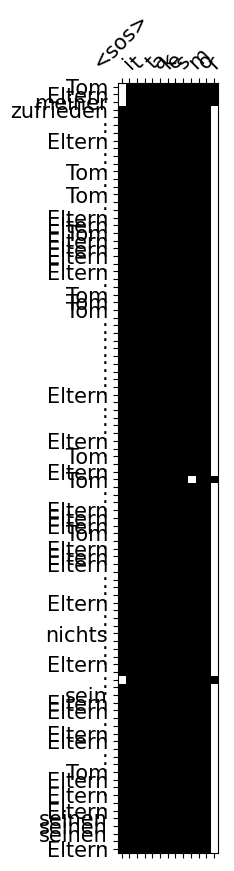

In [43]:
display_attention(input, translation, attention)

In [44]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, max_length = 50):
    
    trgs = []
    pred_trgs = []
    
    for (input, target) in data:
        pred_trget, _ = translate_sentence(input, max_length=max_length)
        target = lang2_tokenizer(target)
        #cut off <eos> token
        pred_trget = pred_trget[:-1]
        
        pred_trgs.append(pred_trget)
        trgs.append(target)
        
    return bleu_score(pred_trgs, trgs)

In [45]:
def calculate_data_bleu(n_num=100):
    data = [random.choice(dataset.untokenized_data) for i in range(n_num)]
    bleu_score = calculate_bleu(data)
    return bleu_score

score = calculate_data_bleu()
print(f'BLEU score = {score*100:.2f}')

BLEU score = 0.00
